# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 20.05.2022**

**Мягкий дедлайн: 03.06.2022 23:59 MSK**

**Жёсткий дедлайн: 08.06.2022 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [2]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/Colab Notebooks/ML2_course/homework-practice-13-recommendations/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [10]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


In [11]:
tracks_info[tracks_info['name'] == 'Never Gonna Give You Up']

,id,name,artists
6055,6055,Never Gonna Give You Up,['Rick Astley']
6067,6067,Never Gonna Give You Up,['Rick Astley']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def mapk_version1(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    ap_k = []
    n_u = np.array([len(x) for x in relevant])
    denominator = np.where(n_u < k, n_u, k)

    for u in range(len(relevant)):
        user_u_rel = relevant[u]
        user_u_pred = predicted[u]

        r_u = np.isin(user_u_pred[:k], user_u_rel)
        precision_u = np.array([r_u[:i].mean() for i in range(1, r_u.shape[0]+1)])
        
        ap_u_k = (precision_u * r_u).sum() / denominator[u]
        ap_k.append(ap_u_k)

    return np.mean(ap_k)

In [5]:
def mapk(relevant: List[List[int]], predicted: np.array, k: int = 20):
    nu = np.array([len(x) for x in relevant])
    min_k_nu = np.where(nu < k, nu, k)
    
    r_u = np.array([np.isin(predicted[u, :k], relevant[u]) for u in range(predicted.shape[0])])
    precision_u = np.array([r_u[:, :i].mean(axis=1) for i in range(1, r_u.shape[1]+1)])
    
    avg_precision_u = (r_u.T * precision_u).sum(axis=0) / min_k_nu
    
    return avg_precision_u.mean()

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = np.array([
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
])

assert round(mapk_version1(relevant, pred, k=5), 4) == 0.4331
assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [12]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [13]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [14]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)
    
    return uencoder, iencoder

In [15]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [16]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [17]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


In [18]:
train_ratings.shape[0], test_ratings.shape[0]

(129404, 6133)

Соберем все релевантные треки для каждого пользователя в список.

In [19]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [20]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
            
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        
        for u in range(self.n_users):
            test_preds.append(self.recommend(u))
        
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [ ]:
(np.ones([5, 15]) @ np.arange(15)) / np.sqrt(np.sum(np.ones([5, 15]) ** 2, axis=1) * np.sum(np.arange(15) ** 2))

array([0.85096294, 0.85096294, 0.85096294, 0.85096294, 0.85096294])

In [29]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    return (ratings @ user_vector) / np.sqrt(np.sum(ratings ** 2, axis=1) * np.sum(user_vector ** 2))
    # shape [n-1 users]

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    return (ratings * user_vector).sum(axis=1) / (ratings + user_vector != 0).sum(axis=1)

In [ ]:
pearson(np.ones([5, 15]), np.ones(15))

array([1., 1., 1., 1., 1.])

In [ ]:
jaccard(np.ones([5, 15]), np.ones(15))

array([1., 1., 1., 1., 1.])

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [27]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02
    
    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        sim_uv = self.similarity_func(self.R, user_vector)
        neighbours = np.where(sim_uv > self.alpha)[0]
        
        return (sim_uv[neighbours] @ self.R[neighbours, :]) / sim_uv[neighbours].sum()
    
    def recommend(self, uid: int):
        user_vector = self.R[uid]
        r_hat = self.similarity(user_vector)
        
        return np.argsort(-r_hat)

**Как работает класс и подбор рекоммендаций**

In [102]:
ratings = train_ratings

In [103]:
n_users = len(np.unique(ratings['userId']))
n_items = len(np.unique(ratings['trackId']))

R = np.zeros((n_users, n_items))
R[ratings['userId'], ratings['trackId']] = 1.
R.shape

(241, 67313)

In [104]:
def pearson_sim(user_vector: np.array):
    sim_uv = pearson(R, user_vector)
    neighbours = np.where(sim_uv > 0.02)[0]
    return (sim_uv[neighbours] @ R[neighbours, :]) / sim_uv[neighbours].sum()

In [105]:
%%time
preds = []
for u in range(241):  # n_users = 241
    user_vector = R[u]
    r_hat = pearson_sim(user_vector)
    preds.append(np.argsort(-r_hat))

CPU times: user 25.6 s, sys: 16.1 s, total: 41.7 s
Wall time: 25.3 s


In [116]:
preds[-2:]

[array([11493,  1073,  2814, ..., 30784, 30995, 67312]),
 array([18459, 24500, 43228, ..., 26094, 26098, 67312])]

In [121]:
k = 5
new_preds = np.zeros((len(preds), k), dtype=int)
for user_id, user_data in ratings.groupby('userId'):
    user_preds = preds[user_id]
    new_preds[user_id] = user_preds[~np.isin(user_preds, user_data['trackId'])][:k]

In [111]:
new_preds

array([[ 9693,  7533,  6376,  1073,  2813],
       [24500,  2814, 33436,   805,  1073],
       [ 1073,  1019, 11493,  2555,  4032],
       ...,
       [ 1019,   805,  9694,  7533, 33436],
       [  805,  7533,  4032,  1056,  9694],
       [18070, 33436,  2814,  8263, 41502]])

In [108]:
new_preds[:2]

array([[ 9693,  7533,  6376,  1073,  2813],
       [24500,  2814, 33436,   805,  1073]])

In [123]:
new_preds[test_users].shape

(235, 5)

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [63]:
%%time
u2u_pearson = User2User(ratings=train_ratings, 
                        similarity_func=pearson)
preds_p = u2u_pearson.get_test_recommendations(30)

CPU times: user 26.1 s, sys: 14.3 s, total: 40.4 s
Wall time: 22.1 s


In [30]:
%%time
u2u_jaccard = User2User(ratings=train_ratings, 
                        similarity_func=jaccard)
preds_j = u2u_jaccard.get_test_recommendations(30)

CPU times: total: 40.9 s
Wall time: 40.5 s


In [65]:
preds_r = np.random.randint(preds_p.min(), preds_p.max(), size=preds_p.shape)

**Графики зависимости MAP@k от k.**

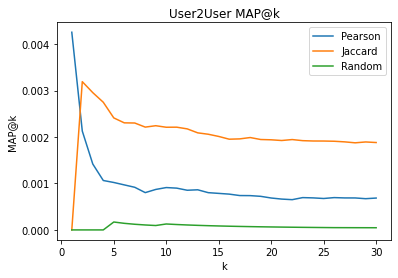

In [66]:
mapk_p, mapk_j, mapk_r = [], [], []
for k in np.arange(1,31):
    mapk_p.append(mapk(test_relevant, preds_p, k))
    mapk_j.append(mapk(test_relevant, preds_j, k))
    mapk_r.append(mapk(test_relevant, preds_r, k))

plt.title('User2User MAP@k')
plt.plot(np.arange(1,31), mapk_p, label='Pearson')
plt.plot(np.arange(1,31), mapk_j, label='Jaccard')
plt.plot(np.arange(1,31), mapk_r, label='Random')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend();

**Бонус (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [38]:
# Поменяем функцию похожести для работы с scipy.sparse.csc_array форматом
def pearson_sparse(ratings: np.array, user_vector: np.array) -> np.array:
    return np.sum(ratings * user_vector, axis=1) / np.sqrt(np.sum(ratings.multiply(ratings), axis=1) * np.sum(user_vector.multiply(user_vector)))

# jaccard_sparse не получилось, так как в scipy.sparse нет быстрого сложения матриц, которое нужно для подсчета объединения векторов.

In [22]:
class User2User_sparse(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        self.similarity_func = similarity_func
        self.alpha = 0.02

        # Переводим в sparse формат
        self.R = scs.csc_array(self.R)

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        sim_uv = self.similarity_func(self.R, user_vector)
        neighbours = np.where(sim_uv > self.alpha)[0]
        
        return (sim_uv[neighbours] @ self.R[neighbours, :]) / sim_uv[neighbours].sum()
    
    def recommend(self, uid: int):
        user_vector = self.R[uid:uid+1]  # в scipy.sparse нет одномерных срезов
        r_hat = self.similarity(user_vector)
        return np.argsort(-r_hat)

In [24]:
# !pip3 install scipy==1.8.1 
# csc_array формат есть в scipy начиная с версии 1.8.0

In [25]:
%%time
u2u_pearson_sparse = User2User_sparse(ratings=train_ratings, 
                                      similarity_func=pearson_sparse)
preds_p = u2u_pearson_sparse.get_test_recommendations(30)

CPU times: total: 3.28 s
Wall time: 3.28 s


In [31]:
%%time
u2u_pearson = User2User(ratings=train_ratings, 
                        similarity_func=pearson)
preds_p = u2u_pearson.get_test_recommendations(30)

CPU times: total: 42.9 s
Wall time: 26.4 s


Прирост в скорости почти в 10 раз!!!

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [ ]:
np.random.seed(2022)
user_id = np.random.randint(0, u2u_jaccard.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
70,Your Heart Is As Black As Night,['Melody Gardot']
102,Just Dance,"['Lady Gaga', ""Colby O'Donis""]"
164,My Favourite Game,['The Cardigans']
281,London Bridge,['Fergie']
300,All Star,['Smash Mouth']
303,I'm A Believer,['Smash Mouth']
353,"Money, Money, Money",['ABBA']
464,Tainted Love,['Marilyn Manson']
512,Du Hast,['Rammstein']
615,Unfaithful,['Rihanna']


In [ ]:
preds = u2u_jaccard.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
7284,Toxicity,['System of A Down']
10472,Королевство Кривых,['Пикник']
13029,Bad Boys (Theme From Cops),['Inner Circle']
3191,Riders on the Storm,['The Doors']
7780,ИСКАЛА,['Земфира']
8010,Je veux,['Zaz']
10468,У шамана три руки,['Пикник']
761,Unchained Melody,['The Righteous Brothers']
13433,Voyage Voyage,['Desireless']
3211,Crazy,['Gnarls Barkley']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
64972,MONTERO (Call Me By Your Name),['Lil Nas X']
65049,Уже все равно,['AMCHI']
65175,Восемь,['Лилу45']
65193,Сон,"[""Ramil'""]"
65380,Leck,"['MORGENSHTERN', 'Imanbek', 'Fetty Wap', 'KDDK']"
65424,Save Your Tears,"['The Weeknd', 'Ariana Grande']"
65440,Fairytale,['Александр Рыбак']
65605,Провода,['просто Лера']
65609,От Винта!,['Смешарики']
65668,АМУР,"['VAVAN', 'Лилая']"


Не очень, в релевантных треках у нас типичный представитель поколения тиктока, тогда как в рекомендациях думер с набором из SoaD, The Doors и Земфиры. Но стоит отметить, что один и тот же человек вполне может слушать и то, и другое.

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 6 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

Функция потерь:
$ L = \sum_{(u, i) \in R} (p_u^T q_i - r_{ui})^2 + \lambda \sum_{u \in U} p_u^T p_u + \lambda \sum_{i \in I} q_i^T q_i$.

**LFM:** С помощью SGD обновляем сразу два вектора.\
Ответ:
$$
L'_{p_u} = 2(p_u^T q_i - r_{ui})\cdot q_i + 2\lambda p_u, \quad
p_u^{new} = p_u^{old} + \eta L'_{p_u}.
$$
$$
L'_{q_i} = 2(p_u^T q_i - r_{ui})\cdot p_u + 2\lambda q_i, \quad
q_i^{new} = q_i^{old} + \eta L'_{q_i}.
$$
\
**ALS:** Так как при фиксировании $p$ или $q$ наш функционал становится выпуклым, то можно поочередно обновлять одни вектора при фиксации других. \
Более того, можно выписать аналитическое решение, так как по сути задача становится похожа задачу гребневой регресии.

Ответ:
$$
\nabla_{p_u} L = 2\sum_i (p_u^T q_i - r_{ui})\cdot q_i^T + 2\lambda p_u^T = 0, 
$$
$$
p_u^T \sum_i q_i q_i^T - \sum_i r_{ui} q_i^T + \lambda p_u^T = 0, 
$$
$$
\left(\sum_i q_i q_i^T + \lambda I \right)p_u = \sum_i r_{ui} q_i, 
$$
$$
p_u = \left(\sum_i q_i q_i^T + \lambda I\right)^{-1}\sum_i r_{ui} q_i.
$$

$$
\nabla_{q_i} L = 2\sum_i (p_u^T q_i - r_{ui})\cdot p_u^T + 2\lambda q_i^T = 0, 
$$
$$
q_i^T \sum_i p_u p_u^T - \sum_i r_{ui} p_u^T + \lambda q_i^T = 0, 
$$
$$
\left(\sum_i p_u p_u^T + \lambda I \right)q_i = \sum_i r_{ui} p_u, 
$$
$$
q_i = \left(\sum_i (p_u p_u^T) + \lambda I\right)^{-1}\sum_i r_{ui} p_u. 
$$











**Задание 7 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [29]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd', use_loss=False):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01
        
        self.use_loss = use_loss
        self.loss_history = []
        
    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            
            if self.mode == 'sgd':
                u = np.random.randint(0, self.n_users)  # batch_size = 1
                nonzero_mask = np.where(self.R[u] != 0)[0]
                i = np.random.choice(nonzero_mask)
                dL_dp = 2 * (self.P[u] @ self.Q[i] - self.R[u, i]) * self.Q[i] + 2 * self.lamb * self.P[u]
                dL_dq = 2 * (self.P[u] @ self.Q[i] - self.R[u, i]) * self.P[u] + 2 * self.lamb * self.Q[i]
                self.P[u] -= self.lr * dL_dp
                self.Q[i] -= self.lr * dL_dq

            elif self.mode == 'als':
                # https://github.com/esokolov/ml-course-hse/blob/master/2021-spring/seminars/sem24-recommendations.ipynb
                RQ = self.R @ self.Q
                for u in range(self.n_users):
                    relevant_items = np.where(self.R[u] == 1)
                    Q_rel = self.Q[relevant_items]
                    QQ = Q_rel.reshape(-1, self.dim, 1) * Q_rel.reshape(-1, 1, self.dim)
                    self.P[u] = np.linalg.inv(QQ.sum(axis=0) + self.lamb * np.eye(self.dim)) @ RQ[u]
                    
                RP = self.R.T @ self.P
                for i in range(self.n_items):
                    relevant_users = np.where(self.R[:, i] == 1)
                    P_rel = self.P[relevant_users]
                    PP = P_rel.reshape(-1, self.dim, 1) * P_rel.reshape(-1, 1, self.dim)
                    self.Q[i] = np.linalg.inv(PP.sum(axis=0) + self.lamb * np.eye(self.dim)) @ RP[i]
                
            if self.use_loss:
                reg = self.lamb * (np.sum(self.P ** 2) + np.sum(self.Q ** 2))
                mse = np.sum((self.R - self.R * (self.P @ self.Q.T)) ** 2)
                self.loss_history.append(mse + reg)
                
    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [24]:
# Baseline LFM
lfm = HiddenVars(train_ratings, dim=128, mode='sgd')
lfm.fit()

preds_lfm = lfm.get_test_recommendations(30)
mapk(test_relevant, preds_lfm, k=30)

  0%|          | 0/5 [00:00<?, ?it/s]

2.6711230673079537e-05

In [ ]:
# Baseline ALS
als = HiddenVars(train_ratings, dim=128, mode='als')
als.fit()

preds_als = als.get_test_recommendations(30)
mapk(test_relevant, preds_als, k=30)

  0%|          | 0/5 [00:00<?, ?it/s]

0.00033672260189821846

**LFM fine tuning**

Подсчет лоссов на каждой итерации занимает очень много времени, обучение проходит в разы быстрее, если выставить `use_loss=False`.

In [36]:
%%time
dim_all = [64, 128, 256]
k_all = [10, 20, 30, 50]
mapk_lfm = []

for dim in dim_all:
    model = HiddenVars(train_ratings, dim=dim, mode='sgd')
    model.fit(num_iters=int(1e5))
    
    for k in k_all:
        pred = model.get_test_recommendations(k)
        mapk_lfm.append([mapk(test_relevant, pred, k=k), dim, k])

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

CPU times: user 2min 41s, sys: 28.4 s, total: 3min 10s
Wall time: 2min 42s


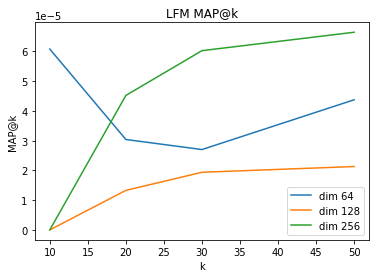

In [48]:
plt.title('LFM MAP@k')
mapk_lfm = np.array(mapk_lfm)
for dim in dim_all:
    plt.plot(k_all, mapk_lfm[mapk_lfm[:, 1] == dim][:, 0], label=f'dim {dim}')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend();

Лучший размер скрытого пространства - 256.


**Качество в зависимости от итераций LFM**

In [73]:
%%time
iter_all = [100, 500, 1000, 1e4, 1e5]
k_all = [10, 20, 30, 50]
models_lfm = []
mapk_lfm = []

for iter in iter_all:
    model = HiddenVars(train_ratings, dim=256, mode='sgd')
    model.fit(num_iters=int(iter))
    models_lfm.append(model)
    
    for k in k_all:
        pred = model.get_test_recommendations(k)
        mapk_lfm.append([mapk(test_relevant, pred, k=k), iter, k])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

CPU times: user 3min 55s, sys: 1min 15s, total: 5min 10s
Wall time: 3min 58s


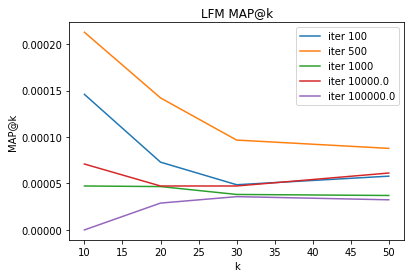

In [74]:
plt.title('LFM MAP@k')
mapk_lfm = np.array(mapk_lfm)
for iter in iter_all:
    plt.plot(k_all, mapk_lfm[mapk_lfm[:, 1] == iter][:, 0], label=f'iter {iter}')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend();

Видно, что LFM переобучается с ростом числа итераций и, смотря на первые 50 предсказаний, лучше всего обучилась модель всего с 500 итерациями и размерностью скрытого пространства 256. Наибольший MAP@k достигается на первых k = 10 рекоммендациях.

In [75]:
best_lfm = models_lfm[1]

**ALS fine tuning**

Для модели ALS требуется меньшее количество итераций, так как на каждом шаге она оптимизирует сначала все скрытые вектора пользователей, а потом все скрытые вектора объектов, тогда как LFM на каждом шаге двигается в сторону антиградиента всего на одной случайной паре (u, i).

In [53]:
%%time
dim_all = [64, 128, 256]
k_all = [10, 20, 30, 50]
models_als = []
mapk_als = []

for dim in dim_all:
    model = HiddenVars(train_ratings, dim=dim, mode='als')
    model.fit(num_iters=3)
    models_als.append(model)
    
    for k in k_all:
        pred = model.get_test_recommendations(k)
        mapk_als.append([mapk(test_relevant, pred, k=k), dim, k])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 32min 33s, sys: 16min 24s, total: 48min 58s
Wall time: 27min 26s


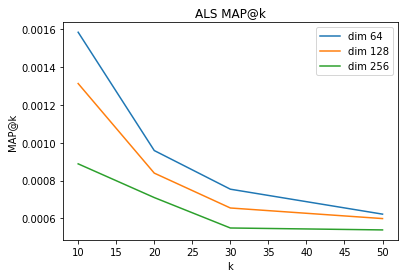

In [56]:
plt.title('ALS MAP@k')
mapk_als = np.array(mapk_als)
for dim in dim_all:
    plt.plot(k_all, mapk_als[mapk_als[:, 1] == dim][:, 0], label=f'dim {dim}')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend();

Лучший размер скрытого пространства - 64.

**Качество в зависимости от итераций ALS**

In [67]:
%%time
iter_all = [1, 2, 3, 4, 5]
k_all = [10, 20, 30, 50]
models_als_iter = []
mapk_als_iter = []

for iter in iter_all:
    model = HiddenVars(train_ratings, dim=64, mode='als')
    model.fit(num_iters=iter)
    models_als_iter.append(model)
    
    for k in k_all:
        pred = model.get_test_recommendations(k)
        mapk_als_iter.append([mapk(test_relevant, pred, k=k), iter, k])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 8min 14s, sys: 4min 27s, total: 12min 42s
Wall time: 7min 31s


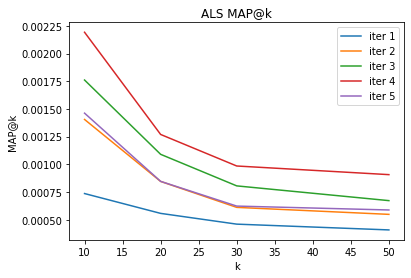

In [68]:
plt.title('ALS MAP@k')
mapk_als_iter = np.array(mapk_als_iter)
for iter in iter_all:
    plt.plot(k_all, mapk_als_iter[mapk_als_iter[:, 1] == iter][:, 0], label=f'iter {iter}')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend();

Из двух моделей со скрытыми переменными лучше себя показала ALS с размерностью скрытого пространства 64 и количеством итераций 4. Наибольший MAP@k достигается на первых k = 10 рекоммендациях.

In [76]:
best_als = models_als_iter[3]

**Сравнение всех подходов на графиках зависимости MAP@k от k**

In [77]:
mapk_hv_lfm, mapk_hv_als = [], []
preds_hv_als = best_als.get_test_recommendations(30)
preds_hv_lfm = best_lfm.get_test_recommendations(30)

for k in np.arange(1,31):
    mapk_hv_als.append(mapk(test_relevant, preds_hv_als, k))
    mapk_hv_lfm.append(mapk(test_relevant, preds_hv_lfm, k))

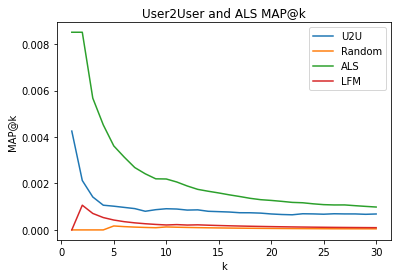

In [82]:
plt.title('User2User and ALS MAP@k')
plt.plot(np.arange(1,31), mapk_p, label='U2U')
plt.plot(np.arange(1,31), mapk_r, label='Random')
plt.plot(np.arange(1,31), mapk_hv_als, label='ALS')
plt.plot(np.arange(1,31), mapk_hv_lfm, label='LFM')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend();

ALS круче всех, так как вектора представлений хорошо могут характеризовать похожесть треков и пользователей. И при обучении ALS мы попеременно находим аналитическое решение минимизации функционала для пользователей и треков, а не случайно двигаемся в сторону антиградиента, что может привести к проблеме локального минимума.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [83]:
model = best_als

In [99]:
example_trackId = tracks_info[tracks_info.name == 'Полковнику никто не пишет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:10]

In [100]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5521,Полковнику никто не пишет,['Би-2'],1.000000
10282,Владивосток 2000,['Мумий Тролль'],0.685193
14484,Прогулки по воде,['Nautilus Pompilius'],0.638836
7780,ИСКАЛА,['Земфира'],0.628565
9694,We Will Rock You,['Queen'],0.628164
28887,Дурак и молния,['Король и Шут'],0.618877
39693,Кукушка,['КИНО'],0.615320
5844,Штиль,['Ария'],0.607981
44188,Мокрые кроссы,['Тима Белорусских'],0.607805
5517,Варвара,['Би-2'],0.605733


In [98]:
example_trackId = tracks_info[tracks_info.name == 'Paint It Black'].iloc[0].id
preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)
track_idxs = preds.argsort()[::-1][:10]

similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
1808,Как остаться Человеком,['Distemper'],1.0
61590,Поле чудес,['Голос Омерики'],1.0
59588,Мы ножи не носим,['Distemper'],1.0
62422,Сам себе соперник,['Включай Микрофон!'],1.0
46037,#линиидворыподворотнипарадные,['Включай Микрофон!'],1.0
8478,Estampida,['Ska-P'],1.0
50169,Дерзость и молодость,['F.P.G.'],1.0
41997,Star Wars Theme,['Melbourne Ska Orchestra'],1.0
59713,Где твой Punk Rock? Пиздабол!,['Distemper'],1.0
5955,Paint It Black,['The Unseen'],1.0


Выходит, что с русскоязычными песнями расстояния между векторами более показательны, чем с зарубежными. Скорее всего из-за того, что в выборке их прослушивают больше пользователей по сравнению с иностранными. 

**Бонус (0.01 балла).** Опишите свои впечатления от коллоквиума. Что следует поменять, чтобы впечатления стали лучше?

Все норм, только немного напрягает неравномерность оценок и разброс в сложности задач среди проверяющих.